In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display

from src.wavhelp import WavHelper

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [2]:
metadata = pd.read_csv('UrbanSoundDatasetSample/metadata/UrbanSound8K.csv')

In [3]:
display(metadata.head())
print(metadata.shape)

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


(8732, 8)


Only need a few file names for this example. Parse with os.listdir

In [4]:
existing_files = os.listdir('UrbanSoundDatasetSample/audio')
metasub = metadata[metadata['slice_file_name'].isin(existing_files)].reset_index(drop=True)
metasub

,slice_file_name,fsID,start,end,salience,fold,classID,class_name
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
3,100852-0-0-0.wav,100852,0.000000,4.000000,1,5,0,air_conditioner
4,101848-9-0-0.wav,101848,0.000000,4.000000,1,7,9,street_music
5,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
6,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
7,102857-5-0-0.wav,102857,0.000000,4.000000,1,10,5,engine_idling
8,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
9,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling


In [5]:
print(metasub.class_name.value_counts())

air_conditioner     1
drilling            1
street_music        1
siren               1
children_playing    1
engine_idling       1
jackhammer          1
gun_shot            1
car_horn            1
dog_bark            1
Name: class_name, dtype: int64


In [6]:
## For sample of Urban sound dataset... will have to be amended for entire dataset
# file_name = os.path.join(os.path.abspath('/UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))

wavfilehelper = WavHelper()
audiodata = []
for index, row in metasub.iterrows():
    
    file_name = os.path.join('UrbanSoundDatasetSample/audio', str(row["slice_file_name"]))
    
    data = wavfilehelper.get_file_props(file_name)
    audiodata.append(data)

# Convert to pandas dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [7]:
audiodf

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16
5,2,44100,16
6,2,44100,16
7,2,44100,16
8,2,48000,24
9,2,44100,16


Primarily 44.1k SR, 16 bit depth, but some variation. Account for this with the librosa load functionality

In [8]:
print(audiodf.num_channels.value_counts(normalize=True))

2    1.0
Name: num_channels, dtype: float64


In [9]:
print(audiodf.sample_rate.value_counts(normalize=True))

44100    0.9
48000    0.1
Name: sample_rate, dtype: float64


In [10]:
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.9
24    0.1
Name: bit_depth, dtype: float64


In [11]:
max_pad_len = 174

def extract_features(fname, features='mfccs'):
    
    try:
        signal, rate = librosa.load(fname, res_type='kaiser_fast') # default is kaiser best. Downsampling later anyways.
        if features == 'mfccs':
            vec = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=40)
        elif features == 'mels':
            vec = librosa.feature.melspectrogram(y=signal, sr=rate, n_mels=60)
#             vec = librosa.power_to_db(vec)
        pad_width = max_pad_len - vec.shape[1]
        vec = np.pad(vec, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error while parsing file: ", fname)
        return None
    
    return vec

In [12]:
datasetpath = 'UrbanSoundDatasetSample/audio/'

features = []

#iterating through each row
for index, row in metasub.iterrows():
    
    file_name = os.path.join(datasetpath, str(row["slice_file_name"]))
    label = row['class_name']
    fold = row["fold"]
    vector = extract_features(file_name, 'mels')

    
    features.append([vector, label, fold])

featuresdf = pd.DataFrame(features, columns=['feature', 'class_label', 'fold'])

In [13]:
features[0][0].shape

(60, 174)

In [14]:
display(featuresdf)
print(featuresdf.shape)

,feature,class_label,fold
0,"[[0.00015100525, 0.00014170613, 0.00013727874,...",dog_bark,5
1,"[[0.020249717, 0.035944887, 0.021877488, 0.026...",children_playing,5
2,"[[0.0010503497, 0.007112698, 0.011476202, 0.00...",car_horn,10
3,"[[2.9233718e-06, 0.0705473, 1.8070649, 12.4267...",air_conditioner,5
4,"[[0.3527452, 0.4210949, 0.31309783, 0.36565572...",street_music,7
5,"[[47.233067, 55.38184, 42.464436, 41.443974, 2...",gun_shot,1
6,"[[0.13007168, 0.13769388, 0.10224321, 0.199294...",siren,7
7,"[[151.7741, 128.39484, 84.23963, 67.139145, 10...",engine_idling,10
8,"[[0.97118616, 0.5512772, 0.3870931, 0.650693, ...",jackhammer,1
9,"[[2.3284926e-07, 8.215059e-06, 4.199208e-05, 0...",drilling,3


(10, 3)


In [15]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
folds = np.array(featuresdf.fold.tolist())
# Encode the classification labels
le = LabelEncoder()
y = to_categorical(le.fit_transform(y)) 

# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state = 42)


In [16]:

### store the preprocessed data for use in the next notebook

# %store X_train 
# %store X_test 
# %store y_train 
# %store y_test 
# %store y_cat 
# %store le

In [17]:
### or... we can pickle that:
import pickle

vec_type = 'mels'
processed_data = (X, y, folds)
data_path = os.path.join('pickles', 'sample_urbansound_'+ vec_type + '.p')

with open(data_path, 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=2)

In [18]:
with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

X, y, folds = data[0], data[1], data[2]

In [19]:
from sklearn.model_selection import LeaveOneGroupOut

In [20]:
y

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D


def get_conv_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    model.summary()
    return model

num_rows = 60
num_columns = 174
num_channels = 1
X = X.reshape(X.shape[0], num_rows, num_columns, num_channels)
num_labels = y.shape[1]


In [22]:
logo = LeaveOneGroupOut()
# print("n_splits=", logo.get_n_splits(X,y,folds))
for train_idx, test_idx in logo.split(X, y, folds):
#     print("train_idx:", train_idx, "test_idx:", test_idx)
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    model = get_conv_model()
    history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test))
    print('fold', folds[test_idx][0])
#     model.score(X_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 59, 173, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 41, 64)        8

Epoch 3/4
7/7 [==============================] - 0s 11ms/sample - loss: 1.7030 - accuracy: 0.2857 - val_loss: 2.7705 - val_accuracy: 0.0000e+00
Epoch 4/4
7/7 [==============================] - 0s 10ms/sample - loss: 1.5151 - accuracy: 0.4286 - val_loss: 2.8824 - val_accuracy: 0.0000e+00
fold 5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 59, 173, 16)       80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 29, 86, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 29, 86, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_13 (MaxPo

In [23]:
history.history

{'loss': [2.2709503173828125,
  1.9574347734451294,
  1.8160529136657715,
  1.6754207611083984],
 'accuracy': [0.125, 0.25, 0.25, 0.375],
 'val_loss': [2.4424047470092773,
  2.5891642570495605,
  2.712027072906494,
  2.835966110229492],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0]}

In [24]:
max(history.history['val_accuracy'])

0.0

In [25]:
history.history['val_accuracy']

[0.0, 0.0, 0.0, 0.0]

In [27]:
#### checking class imbalance on FULL dataset

In [28]:
data_path = os.path.join('pickles', 'urbansound_'+ vec_type + '.p')

with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

X, y, folds = data[0], data[1], data[2]


In [34]:
from sklearn.utils.class_weight import compute_class_weight

In [38]:
y_flat = np.argmax(y, axis=1)

array([3, 2, 2, ..., 1, 1, 1])

In [75]:
class_weights = compute_class_weight(class_weight='balanced' , classes=np.unique(y_flat), y=y_flat )

In [45]:
y_labels = le.inverse_transform(y_flat)
y_labels

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

(array([1000., 1000.,  429., 1000., 1000.,  374.,  929., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

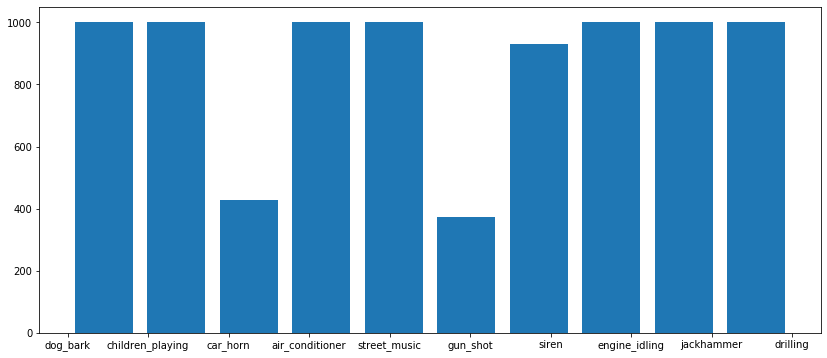

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(14,6))

ax.hist(y_labels, align='mid', rwidth=0.8)

In [79]:
unique_labels, counts = np.unique(y_flat, return_counts=True)

In [80]:
counts

array([1000,  429, 1000, 1000, 1000, 1000,  374, 1000,  929, 1000])

In [81]:
class_weights

array([0.8732    , 2.03543124, 0.8732    , 0.8732    , 0.8732    ,
       0.8732    , 2.33475936, 0.8732    , 0.93993541, 0.8732    ])

In [82]:
class_weights * counts

array([873.2, 873.2, 873.2, 873.2, 873.2, 873.2, 873.2, 873.2, 873.2,
       873.2])